In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error # Ensure this is imported

# --- 1. Load and Process CSV Data to get Target Net Profile for a SPECIFIC DAY ---
def get_target_day_profile(csv_file_path, target_date_str, time_step_minutes=5):
    """
    Loads CSV data, filters for a specific day, and returns its net power profile.
    """
    try:
        df_actual = pd.read_csv(csv_file_path)
    except FileNotFoundError:
        print(f"Error: The file {csv_file_path} was not found.")
        return None

    df_actual['X-Data'] = pd.to_datetime(df_actual['X-Data'])
    
    target_col_original = 'TOTDemand(kWh/h)Value[kWh/h]'
    target_col_new = 'P_Net_from_CSV_kW' # Renaming to be clear it's net power
    if target_col_original in df_actual.columns:
        df_actual.rename(columns={target_col_original: target_col_new}, inplace=True)
    else:
        print(f"Error: Target column '{target_col_original}' not found in CSV.")
        return None

    # Filter for the specific target date
    target_date = pd.to_datetime(target_date_str)
    df_day = df_actual[df_actual['X-Data'].dt.date == target_date.date()].copy() # Use .copy()
    
    if df_day.empty:
        print(f"No data found for the target date: {target_date_str}")
        return None
        
    df_day.set_index('X-Data', inplace=True)
    
    # Ensure 'AVrmsAvg_Volts' is present for anomaly removal if needed (though for a single day, less likely to hit that specific anomaly)
    voltage_col_original = 'AVrmsAvg[Volts]'
    voltage_col_new = 'AVrmsAvg_Volts' 
    if voltage_col_original in df_day.columns: # Check on df_day now
         df_day.rename(columns={voltage_col_original: voltage_col_new}, inplace=True)

    if voltage_col_new in df_day.columns: # Check on df_day
        anomalous_mask_day = (df_day[voltage_col_new] < 100)
        if anomalous_mask_day.any():
            print(f"Found and removing {anomalous_mask_day.sum()} anomalous rows from target day {target_date_str}.")
            df_day = df_day[~anomalous_mask_day]
            if df_day.empty:
                print(f"All data for {target_date_str} was anomalous. Cannot proceed.")
                return None
    
    # Create a full day index for resampling
    start_of_day = pd.Timestamp(target_date_str).normalize()
    full_day_timedelta_index = pd.to_timedelta(np.arange(0, 24 * 60, time_step_minutes), unit='m')
    full_day_datetime_index = start_of_day + full_day_timedelta_index
    
    # Select only the target power column and reindex to ensure full day coverage
    target_day_profile = df_day[target_col_new].reindex(full_day_datetime_index, method='ffill').fillna(method='bfill')
    
    # For plotting and consistency in generate_combined_profile, use timedelta index from start of day
    target_day_profile.index = target_day_profile.index - target_day_profile.index[0]


    print(f"\nTarget Net Power Profile from CSV for {target_date_str} (first 5 steps):")
    print(target_day_profile.head())
    
    plt.figure(figsize=(12, 6))
    plt.plot(target_day_profile.index.total_seconds() / 3600, target_day_profile.values, label=f'Net Power from CSV ({target_date_str})')
    plt.title(f'Net Power Profile from CSV Data for {target_date_str}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Power (kW)')
    plt.xticks(np.arange(0, 25, 2))
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return target_day_profile



In [45]:
# --- Individual Load Functions (get_house_load, get_borehole_pump1_load, etc.) ---
# These functions remain the same as in the previous script.
# I will omit them here for brevity but assume they are defined above this section.
# Make sure they are included when you run the full script.

# Copied from previous response for completeness:
def get_house_load(time_vector_hours, num_steps):
    pf_houses = 0.9
    p_house_single_peak = 2.5; p_house_single_day = 0.75; p_house_single_night = 0.5
    p_profile = np.zeros(num_steps)
    for i, hour_of_day in enumerate(time_vector_hours):
        if 6 <= hour_of_day < 9: p_profile[i] = 3 * p_house_single_peak
        elif 9 <= hour_of_day < 17: p_profile[i] = 3 * p_house_single_day
        elif 17 <= hour_of_day < 21: p_profile[i] = 3 * p_house_single_peak
        else: p_profile[i] = 3 * p_house_single_night
    q_profile = p_profile * np.tan(np.arccos(pf_houses))
    return p_profile, q_profile, "1ph"



In [46]:
def get_borehole_pump1_load(time_vector_hours, num_steps, start_h=7, duration_h=5):
    p_rated = 1.25; pf_run = 0.8; inrush_factor = 2.5; pf_inrush = 0.6
    p_profile = np.zeros(num_steps); q_profile = np.zeros(num_steps)
    on_indices = (time_vector_hours >= start_h) & (time_vector_hours < start_h + duration_h)
    p_profile[on_indices] = p_rated
    q_profile[on_indices] = p_rated * np.tan(np.arccos(pf_run))
    start_idx = np.where(on_indices)[0]
    if len(start_idx) > 0:
        p_profile[start_idx[0]] = p_rated * inrush_factor
        q_profile[start_idx[0]] = (p_rated * inrush_factor) * np.tan(np.arccos(pf_inrush))
    return p_profile, q_profile, "1ph"



In [47]:
def get_borehole_pump2_load(time_vector_hours, num_steps, start_h=13, duration_h=6):
    p_rated = 2.0; pf_run = 0.8; inrush_factor = 2.5; pf_inrush = 0.6
    p_profile = np.zeros(num_steps); q_profile = np.zeros(num_steps)
    on_indices = (time_vector_hours >= start_h) & (time_vector_hours < start_h + duration_h)
    p_profile[on_indices] = p_rated
    q_profile[on_indices] = p_rated * np.tan(np.arccos(pf_run))
    start_idx = np.where(on_indices)[0]
    if len(start_idx) > 0:
        p_profile[start_idx[0]] = p_rated * inrush_factor
        q_profile[start_idx[0]] = (p_rated * inrush_factor) * np.tan(np.arccos(pf_inrush))
    return p_profile, q_profile, "3ph"



In [48]:
def get_security_fence_load(time_vector_hours, num_steps):
    p_rated = 5.0; pf_fence = 0.95
    p_profile = np.ones(num_steps) * p_rated
    q_profile = p_profile * np.tan(np.arccos(pf_fence))
    return p_profile, q_profile, "3ph"



In [49]:
def get_cold_room_load(time_vector_hours, num_steps, schedule_blocks=[(0,5), (12,17)]):
    p_rated = 2.5; pf_run = 0.8; inrush_factor = 2.5; pf_inrush = 0.6
    p_profile = np.zeros(num_steps); q_profile = np.zeros(num_steps)
    for start_h, end_h in schedule_blocks:
        on_indices_block = (time_vector_hours >= start_h) & (time_vector_hours < end_h)
        p_profile[on_indices_block] = p_rated
        q_profile[on_indices_block] = p_rated * np.tan(np.arccos(pf_run))
        start_idx_block = np.where(on_indices_block)[0]
        if len(start_idx_block) > 0:
            p_profile[start_idx_block[0]] = p_rated * inrush_factor
            q_profile[start_idx_block[0]] = (p_rated * inrush_factor) * np.tan(np.arccos(pf_inrush))
    return p_profile, q_profile, "3ph"



In [50]:
def get_maize_cruncher_load(time_vector_hours, num_steps, schedule_blocks=[(8,11), (13,16)]):
    p_rated = 7.5; pf_run = 0.8; inrush_factor = 3.0; pf_inrush = 0.5
    p_profile = np.zeros(num_steps); q_profile = np.zeros(num_steps)
    for start_h, end_h in schedule_blocks:
        on_indices_block = (time_vector_hours >= start_h) & (time_vector_hours < end_h)
        p_profile[on_indices_block] = p_rated
        q_profile[on_indices_block] = p_rated * np.tan(np.arccos(pf_run))
        start_idx_block = np.where(on_indices_block)[0]
        if len(start_idx_block) > 0:
            p_profile[start_idx_block[0]] = p_rated * inrush_factor
            q_profile[start_idx_block[0]] = (p_rated * inrush_factor) * np.tan(np.arccos(pf_inrush))
    return p_profile, q_profile, "3ph"



In [51]:
def get_feed_mixers_load(time_vector_hours, num_steps, schedule_blocks=[(8,11), (13,16)], num_active_mixers=3): # Default 3 mixers
    p_unit_rated = 7.5; 
    p_total_rated_active = p_unit_rated * num_active_mixers # Power based on active mixers
    pf_run = 0.8; inrush_factor = 3.0; pf_inrush = 0.5
    p_profile = np.zeros(num_steps); q_profile = np.zeros(num_steps)
    for start_h, end_h in schedule_blocks: 
        on_indices_block = (time_vector_hours >= start_h) & (time_vector_hours < end_h)
        p_profile[on_indices_block] = p_total_rated_active
        q_profile[on_indices_block] = p_total_rated_active * np.tan(np.arccos(pf_run))
        start_idx_block = np.where(on_indices_block)[0]
        if len(start_idx_block) > 0:
            # Inrush based on number of active mixers starting
            p_profile[start_idx_block[0]] = p_total_rated_active * inrush_factor 
            q_profile[start_idx_block[0]] = (p_total_rated_active * inrush_factor) * np.tan(np.arccos(pf_inrush))
    return p_profile, q_profile, "3ph"



In [52]:
def get_security_lights_load(time_vector_hours, num_steps):
    p_total = 3.0; pf = 0.95
    on_indices = (time_vector_hours >= 18) | (time_vector_hours < 6)
    p_profile = np.where(on_indices, p_total, 0)
    q_profile = p_profile * np.tan(np.arccos(pf))
    return p_profile, q_profile, "1ph"


In [53]:

def get_electrical_tools_load(time_vector_hours, num_steps, schedule_blocks=[(8,12), (13,17)]):
    p_rated = 1.5; pf_run = 0.8; inrush_factor = 2.0; pf_inrush = 0.65
    p_profile = np.zeros(num_steps); q_profile = np.zeros(num_steps)
    for start_h, end_h in schedule_blocks:
        on_indices_block = (time_vector_hours >= start_h) & (time_vector_hours < end_h)
        p_profile[on_indices_block] = p_rated
        q_profile[on_indices_block] = p_rated * np.tan(np.arccos(pf_run))
        start_idx_block = np.where(on_indices_block)[0]
        if len(start_idx_block) > 0:
            p_profile[start_idx_block[0]] = p_rated * inrush_factor
            q_profile[start_idx_block[0]] = (p_rated * inrush_factor) * np.tan(np.arccos(pf_inrush))
    return p_profile, q_profile, "3ph"




In [54]:
# --- 3. Generate and Sum Profiles ---
# (Assuming all load generation functions and get_target_day_profile are defined above)

def generate_combined_profile_with_assumed_gen(target_net_power_profile, assumed_generation_profile):
    if target_net_power_profile is None or assumed_generation_profile is None:
        print("Cannot generate profile without target net power or assumed generation.")
        return None
    if len(target_net_power_profile) != len(assumed_generation_profile):
        print("Error: Target net power and assumed generation profiles have different lengths.")
        return None
        
    time_step_minutes_td = (target_net_power_profile.index[1] - target_net_power_profile.index[0])
    time_step_minutes = int(time_step_minutes_td.total_seconds() / 60)
    
    total_hours = 24
    num_steps = int(total_hours * (60 / time_step_minutes))
    time_vector_hours = np.linspace(0, total_hours, num_steps, endpoint=False)

    # This is now our target for the sum of individual consumption loads
    target_gross_consumption_profile = assumed_generation_profile - target_net_power_profile.values 

    all_profiles_df = pd.DataFrame(index=target_net_power_profile.index)
    
    # ---- YOU WILL ITERATIVELY ADJUST SCHEDULES HERE in load_configs ----
    # Example: More staggered daytime industrial loads
    # Inside generate_combined_profile_with_assumed_gen function:

    # ---- YOU WILL ITERATIVELY ADJUST SCHEDULES HERE in load_configs ----
    # Inside generate_combined_profile_with_assumed_gen function:

    # ---- YOU WILL ITERATIVELY ADJUST SCHEDULES HERE in load_configs ----
    load_configs = {
        'Houses': {'func': get_house_load, 'args': (time_vector_hours, num_steps)},
        'Borehole_Pump1': {'func': get_borehole_pump1_load, 'args': (time_vector_hours, num_steps, 6, 5)},     # 06:00-11:00
        'Borehole_Pump2': {'func': get_borehole_pump2_load, 'args': (time_vector_hours, num_steps, 17, 6)},     # 17:00-23:00
        'Security_Fence': {'func': get_security_fence_load, 'args': (time_vector_hours, num_steps)},
        'Cold_Room': {'func': get_cold_room_load, 'args': (time_vector_hours, num_steps, 
                                                          [(2,5), (10,12), (15,17), (20,23)])}, # 3h, 2h, 2h, 3h = 10h
        'Maize_Cruncher': {'func': get_maize_cruncher_load, 'args': (time_vector_hours, num_steps, 
                                                                    [(8, 10), (12, 14), (15,17)])}, # 2h+2h+2h = 6h
        
        # Feed Mixers: 5 units available, each needs to run 6 hours/day. Total 30 unit-operating-hours.
        # Schedule blocks for different numbers of mixers to try and distribute the 30 unit-hours
        # over the 08:00-17:00 window (9 hours). Average 3.33 mixers.
        # Block 1: 08:00 - 11:00 (3 hours) with 4 mixers active. (4 units * 3h = 12 unit-hours)
        'Feed_Mixers_Group1': {'func': get_feed_mixers_load, 
                               'args': (time_vector_hours, num_steps, [(8,11)]), 
                               'kwargs': {'num_active_mixers': 4}},
        # Block 2: 11:00 - 14:00 (3 hours) with 3 mixers active. (3 units * 3h = 9 unit-hours)
        'Feed_Mixers_Group2': {'func': get_feed_mixers_load, 
                               'args': (time_vector_hours, num_steps, [(11,14)]), 
                               'kwargs': {'num_active_mixers': 3}},
        # Block 3: 14:00 - 17:00 (3 hours) with 3 mixers active. (3 units * 3h = 9 unit-hours)
        'Feed_Mixers_Group3': {'func': get_feed_mixers_load, 
                               'args': (time_vector_hours, num_steps, [(14,17)]), 
                               'kwargs': {'num_active_mixers': 3}},
        # Total unit-hours = 12 + 9 + 9 = 30. This fulfills the requirement.

        'Security_Lights': {'func': get_security_lights_load, 'args': (time_vector_hours, num_steps)},
        
        # Electrical Tools: 8 hours. Spread out more.
        'Electrical_Tools': {'func': get_electrical_tools_load, 'args': (time_vector_hours, num_steps, 
                                                                        [(8,10),(10.5,12.5),(13,15),(15.5,17.5)])} # 4x2h=8h
    }

    # Modify the loop that calls the functions to handle 'kwargs'
    total_p_simulated_consumption = np.zeros(num_steps)
    print("\n--- Individual Load Schedules (Active Power kW) ---")
    time_step_h = time_step_minutes / 60.0
    for name, config in load_configs.items():
        func_args = config.get('args', ())
        func_kwargs = config.get('kwargs', {}) # Get kwargs, or empty dict if not present
        p, q, phase_type = config['func'](*func_args, **func_kwargs) # Unpack kwargs here
        
        all_profiles_df[f'P_{name}'] = p
        total_p_simulated_consumption += p
        
        # (The rest of the printing loop for schedules remains the same)
        on_indices = np.where(p > 0)[0]
        if len(on_indices) > 0:
            print(f"\nLoad: {name}")
            start_block_idx = -1
            for k_idx in range(len(on_indices)):
                current_actual_idx = on_indices[k_idx]
                if start_block_idx == -1: 
                    start_block_idx = current_actual_idx
                
                is_last_on_index = (k_idx == len(on_indices) - 1)
                is_discontinuous = not is_last_on_index and (on_indices[k_idx+1] != current_actual_idx + 1)
                
                if is_last_on_index or is_discontinuous:
                    end_block_idx = current_actual_idx
                    start_time_h = time_vector_hours[start_block_idx]
                    end_time_h = time_vector_hours[end_block_idx] + time_step_h 
                    print(f"  - Operates from {start_time_h:.2f}h to {end_time_h:.2f}h, Peak P: {np.max(p[start_block_idx:end_block_idx+1]):.2f} kW")
                    start_block_idx = -1 
        else:
            print(f"\nLoad: {name} - Not scheduled to operate / 0 power.")


    all_profiles_df['P_Simulated_Gross_Consumption_kW'] = total_p_simulated_consumption
    all_profiles_df['P_Target_Gross_Consumption_kW'] = target_gross_consumption_profile # This is what we want to match

    # --- Plotting ---
    fig, ax1 = plt.subplots(figsize=(15, 8))

    color = 'tab:green' # Target Gross Consumption
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Target Gross Consumption (kW)', color=color)
    ax1.plot(all_profiles_df.index.total_seconds() / 3600, all_profiles_df['P_Target_Gross_Consumption_kW'], color=color, linestyle='-', label='Target Gross Consumption (Gen - Net CSV)')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, axis='x')

    ax2 = ax1.twinx()
    color = 'tab:red' # Simulated Gross Consumption
    ax2.set_ylabel('Simulated Gross Consumption (kW)', color=color)
    ax2.plot(all_profiles_df.index.total_seconds() / 3600, all_profiles_df['P_Simulated_Gross_Consumption_kW'], color=color, linestyle='--', label='Simulated Gross Consumption')
    ax2.tick_params(axis='y', labelcolor=color)
    
    fig.suptitle('Target Gross Consumption vs. Simulated Gross Consumption')
    # Combine legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    
    plt.xticks(np.arange(0, 25, 2))
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    print("\n--- Generated Individual and Total Simulated Load Profiles (kW) ---")
    print(all_profiles_df.filter(like='P_').head())

    return all_profiles_df



C:\Users\hp\AppData\Local\Temp\ipykernel_17788\1815970315.py:59: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  target_day_profile = df_day[target_col_new].reindex(full_day_datetime_index, method='ffill').fillna(method='bfill')



Target Net Power Profile from CSV for 2025-05-01 (first 5 steps):
0 days 00:00:00   -12.5904
0 days 00:05:00   -10.8600
0 days 00:10:00    -9.8769
0 days 00:15:00    -9.7890
0 days 00:20:00    -8.7326
Name: P_Net_from_CSV_kW, dtype: float64


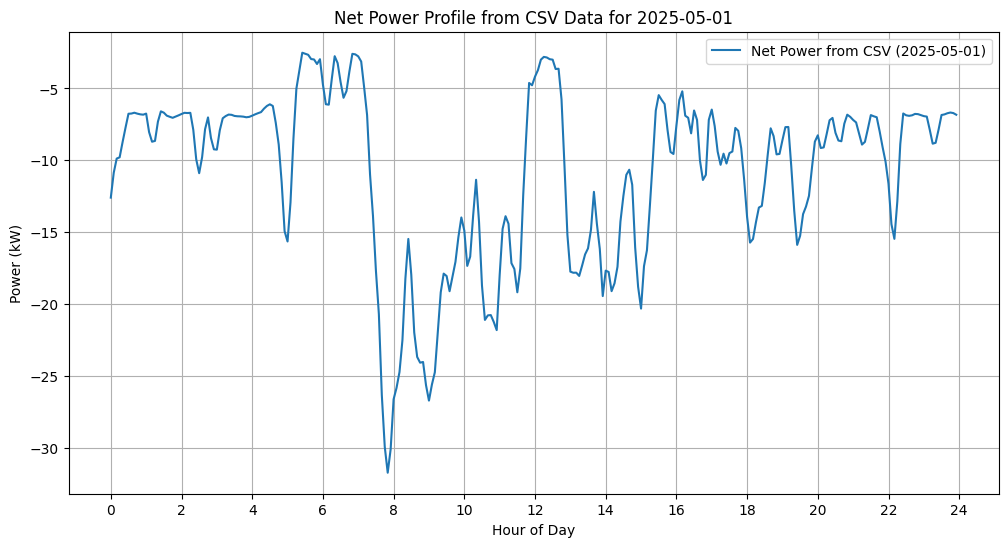


--- Individual Load Schedules (Active Power kW) ---

Load: Houses
  - Operates from 0.00h to 24.00h, Peak P: 7.50 kW

Load: Borehole_Pump1
  - Operates from 6.00h to 11.00h, Peak P: 3.12 kW

Load: Borehole_Pump2
  - Operates from 17.00h to 23.00h, Peak P: 5.00 kW

Load: Security_Fence
  - Operates from 0.00h to 24.00h, Peak P: 5.00 kW

Load: Cold_Room
  - Operates from 2.00h to 5.00h, Peak P: 6.25 kW
  - Operates from 10.00h to 12.00h, Peak P: 6.25 kW
  - Operates from 15.00h to 17.00h, Peak P: 6.25 kW
  - Operates from 20.00h to 23.00h, Peak P: 6.25 kW

Load: Maize_Cruncher
  - Operates from 8.00h to 10.00h, Peak P: 22.50 kW
  - Operates from 12.00h to 14.00h, Peak P: 22.50 kW
  - Operates from 15.00h to 17.00h, Peak P: 22.50 kW

Load: Feed_Mixers_Group1
  - Operates from 8.00h to 11.00h, Peak P: 90.00 kW

Load: Feed_Mixers_Group2
  - Operates from 11.00h to 14.00h, Peak P: 67.50 kW

Load: Feed_Mixers_Group3
  - Operates from 14.00h to 17.00h, Peak P: 67.50 kW

Load: Security_Lights


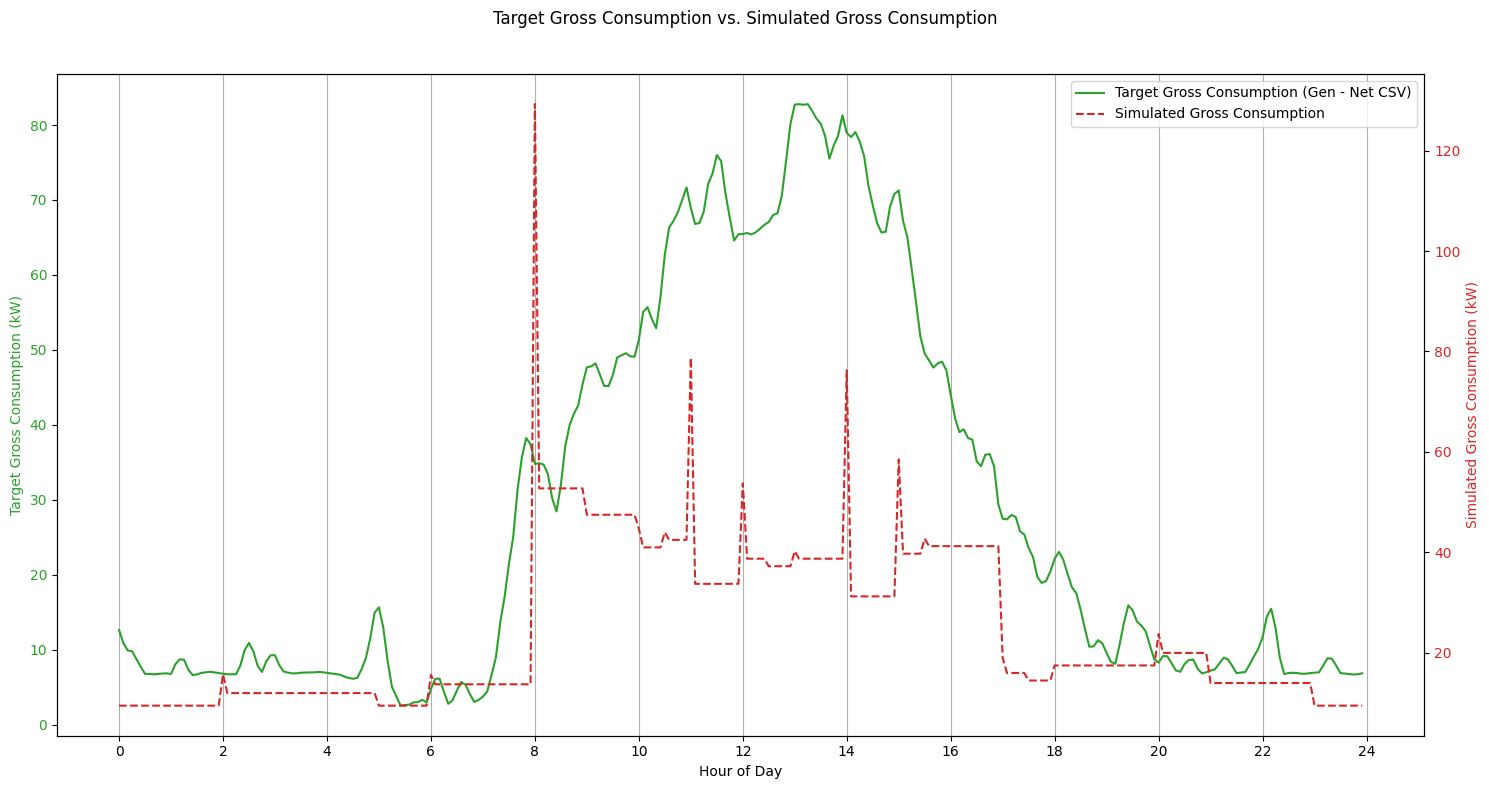


--- Generated Individual and Total Simulated Load Profiles (kW) ---
                 P_Houses  P_Borehole_Pump1  P_Borehole_Pump2  \
0 days 00:00:00       1.5               0.0               0.0   
0 days 00:05:00       1.5               0.0               0.0   
0 days 00:10:00       1.5               0.0               0.0   
0 days 00:15:00       1.5               0.0               0.0   
0 days 00:20:00       1.5               0.0               0.0   

                 P_Security_Fence  P_Cold_Room  P_Maize_Cruncher  \
0 days 00:00:00               5.0          0.0               0.0   
0 days 00:05:00               5.0          0.0               0.0   
0 days 00:10:00               5.0          0.0               0.0   
0 days 00:15:00               5.0          0.0               0.0   
0 days 00:20:00               5.0          0.0               0.0   

                 P_Feed_Mixers_Group1  P_Feed_Mixers_Group2  \
0 days 00:00:00                   0.0                   0.0   
0 day

In [55]:
# --- (Imports and existing load generation functions remain the same) ---

# --- New or Modified Functions ---

def define_load_bank():
    """
    Returns a list of dictionaries, each defining a load's fixed parameters
    and constraints (power, total_hours, window, inrush, type, etc.).
    Flexible loads will also have a placeholder for their current schedule.
    """
    loads = [
        {'name': 'Security_Fence', 'type': 'fixed', 'P_rated': 5.0, 'PF': 0.95, 'phase': '3ph', 
         'schedule_func': get_security_fence_load, 'params': {}}, # params for schedule_func if needed
        {'name': 'Security_Lights', 'type': 'fixed', 'P_rated': 3.0, 'PF': 0.95, 'phase': '1ph', 
         'schedule_func': get_security_lights_load, 'params': {}},
        {'name': 'Houses', 'type': 'profiled', 'PF': 0.9, 'phase': '1ph', 
         'schedule_func': get_house_load, 'params': {}}, # Profile shape is fixed by function
        
        {'name': 'Borehole_Pump1', 'type': 'flexible', 'P_rated': 1.25, 'PF_run': 0.8, 'PF_inrush':0.6, 'inrush_factor':2.5, 'phase': '1ph',
         'total_hours': 5, 'window': (6, 18), 'schedule_func': get_borehole_pump1_load_dynamic, 'current_schedule_params': None},
        # ... other flexible loads ...
        {'name': 'Feed_Mixers', 'type': 'flexible_group', 'P_unit': 7.5, 'num_units': 5, 'unit_hours': 6, 
         'PF_run': 0.8, 'PF_inrush':0.5, 'inrush_factor':3.0, 'phase': '3ph',
         'window': (8,17), 'schedule_func': get_feed_mixers_load_dynamic, 'current_schedule_params': None},
    ]
    return loads

def get_borehole_pump1_load_dynamic(time_vector_hours, num_steps, P_rated, PF_run, PF_inrush, inrush_factor, start_h, duration_h):
    # Similar to existing, but takes all params
    # ... returns p_profile, q_profile
    pass # Placeholder

def get_feed_mixers_load_dynamic(time_vector_hours, num_steps, P_unit, PF_run, PF_inrush, inrush_factor, 
                                 active_mixers_schedule_blocks): # e.g., [ ((8,10), 3), ((10,12), 2) ] (block, num_mixers)
    # ... calculates p based on varying number of active mixers per block
    pass # Placeholder


def generate_candidate_schedules(load_definition, time_vector_hours, time_step_minutes):
    """
    For a given flexible load, generates a set of valid candidate operating schedules.
    This is a key part of the search/optimization.
    Example for a simple pump: iterate through possible start times.
    Example for block load: iterate through combinations of ON/OFF blocks.
    """
    candidate_schedules = [] # List of schedule_params to pass to load_dynamic function
    # ... logic to generate candidates ...
    return candidate_schedules


def evaluate_schedule_fit(simulated_consumption_with_candidate, target_gross_consumption, current_load_on_indices):
    """
    Calculates an error metric. Could be RMSE over the whole profile,
    or focused on how well the candidate schedule helps match the target 
    during its own ON times, or how it impacts the "remaining target".
    """
    # ... calculate error ...
    error = np.sqrt(mean_squared_error(target_gross_consumption[current_load_on_indices], 
                                       simulated_consumption_with_candidate[current_load_on_indices])) 
                                       # Example: RMSE only during ON time of candidate
    return error


def automated_scheduler(target_net_profile_csv, assumed_generation_profile):
    """
    Implements the iterative heuristic scheduling.
    """
    # 1. Calculate P_target_gross = assumed_generation - target_net_csv
    # 2. Initialize load_bank from define_load_bank()
    # 3. Schedule fixed/profiled loads, calculate P_fixed_profiled_sum
    # 4. P_residual_target = P_target_gross - P_fixed_profiled_sum
    
    # 5. For each flexible load in load_bank (in some order):
    #    best_error_for_this_load = infinity
    #    best_schedule_params_for_this_load = None
    #    candidate_schedules = generate_candidate_schedules(load, ...)
    #    
    #    for schedule_params in candidate_schedules:
    #        P_candidate_load, Q_candidate_load = load['schedule_func'](..., **schedule_params)
    #        P_current_total_sim = P_already_scheduled_flexible_loads + P_candidate_load
    #        
    #        # Error could be against (P_residual_target - P_other_flexible_loads_not_yet_scheduled_estimate)
    #        # Or simply how P_current_total_sim + P_fixed_profiled_sum matches P_target_gross
    #        error = evaluate_schedule_fit(P_fixed_profiled_sum + P_current_total_sim, P_target_gross, P_candidate_load > 0)
    #
    #        if error < best_error_for_this_load:
    #            best_error_for_this_load = error
    #            best_schedule_params_for_this_load = schedule_params
    #
    #    Store best_schedule_params_for_this_load in load_bank for current load
    #    Update P_already_scheduled_flexible_loads
    
    # 6. After iterating all flexible loads, assemble final P_simulated_gross_consumption
    # 7. Plot, calculate final metrics.
    # 8. Return all_profiles_df (which includes individual schedules)
    pass


if __name__ == '__main__':
    target_date_to_model = "2025-05-01"
    target_net_profile = get_target_day_profile(r"c:\Users\hp\Desktop\REG108S\Project\MeasuredData_Filled.csv", target_date_to_model)

    if target_net_profile is not None:
        # --- Define an Assumed Generation Profile (P_gen_assumed) ---
        num_steps_gen = len(target_net_profile)
        time_vector_gen_hours = np.linspace(0, 24, num_steps_gen, endpoint=False)
        peak_generation_kw = 65 # ADJUST THIS BASED ON (max(target_gross_consumption) from your last plot)
        p_gen_assumed = np.zeros(num_steps_gen)
        for i, h in enumerate(time_vector_gen_hours):
            if 6.5 <= h < 19.5: # Daylight hours for solar
                p_gen_assumed[i] = peak_generation_kw * (np.sin(np.pi * (h - 6.5) / (19.5 - 6.5)))**2
        assumed_generation_profile_series = pd.Series(p_gen_assumed, index=target_net_profile.index)
        # (Plot assumed generation)

        # This is where the automated scheduler would be called.
        # For now, we are still in manual adjustment phase using the previous script's structure.
        # The call would be:
        # final_scheduled_profiles = automated_scheduler(target_net_profile, assumed_generation_profile_series)
        
        # For now, let's stick to the manual adjustment via load_configs
        # in generate_combined_profile_with_assumed_gen (from previous response)
        # You would take the code from the previous response, ensure the load functions
        # are defined, and then iteratively change the `load_configs` in
        # `generate_combined_profile_with_assumed_gen` and run.
        
        # Using the previously defined function for manual iteration:
        simulated_profiles_df = generate_combined_profile_with_assumed_gen(target_net_profile, assumed_generation_profile_series)
        
        if simulated_profiles_df is not None:
            rmse_match = np.sqrt(mean_squared_error(
                simulated_profiles_df['P_Target_Gross_Consumption_kW'], 
                simulated_profiles_df['P_Simulated_Gross_Consumption_kW']
            ))
            print(f"\nRMSE between Target Gross Consumption and Simulated Gross Consumption: {rmse_match:.2f} kW")

In [56]:
# if __name__ == '__main__':
#     target_date_to_model = "2025-05-01" 
#     target_net_profile = get_target_day_profile(r"c:\Users\hp\Desktop\REG108S\Project\MeasuredData_Filled.csv", target_date_to_model) 
    
#     if target_net_profile is not None:
#         # --- Define an Assumed Generation Profile (P_gen_assumed) ---
#         # This is a CRITICAL assumption. Let's make a very simple solar-like one for now.
#         num_steps_gen = len(target_net_profile)
#         time_vector_gen_hours = np.linspace(0, 24, num_steps_gen, endpoint=False)
        
#         # Simple symmetrical peak for solar (very rough)
#         # Peak generation needs to be estimated. Let's say max export is -25kW, and min daytime consumption is ~10kW (fence+houses)
#         # So, peak generation might be around 35-50kW. Let's try a peak of 45kW.
#         peak_generation_kw = 45 
#         p_gen_assumed = np.zeros(num_steps_gen)
#         for i, h in enumerate(time_vector_gen_hours):
#             if 7 <= h < 19: # Daylight hours
#                 # Simple sine squared shape for solar
#                 p_gen_assumed[i] = peak_generation_kw * (np.sin(np.pi * (h - 7) / (19 - 7)))**2
        
#         assumed_generation_profile_series = pd.Series(p_gen_assumed, index=target_net_profile.index)

#         plt.figure(figsize=(12,4))
#         plt.plot(assumed_generation_profile_series.index.total_seconds()/3600, assumed_generation_profile_series.values, label='Assumed Generation Profile')
#         plt.title('Assumed Daily Generation Profile')
#         plt.xlabel('Hour of Day'); plt.ylabel('Power (kW)'); plt.grid(True); plt.legend(); plt.show()
#         # --- End Assumed Generation Profile ---

#         simulated_profiles_df = generate_combined_profile_with_assumed_gen(target_net_profile, assumed_generation_profile_series)
        
#         if simulated_profiles_df is not None:
#             rmse_match = np.sqrt(mean_squared_error(
#                 simulated_profiles_df['P_Target_Gross_Consumption_kW'], 
#                 simulated_profiles_df['P_Simulated_Gross_Consumption_kW']
#             ))
#             print(f"\nRMSE between Target Gross Consumption and Simulated Gross Consumption: {rmse_match:.2f} kW")
#             print("Iteratively adjust schedules in 'load_configs' to minimize this RMSE and improve visual match.")